In [62]:
# import the packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from collections import Counter
from statistics import mode
import datetime
from sklearn.metrics.pairwise import cosine_similarity
import geopandas
import rtree
import seaborn as sns
import haversine as hs
from sklearn.linear_model import LinearRegression

# 1 Import data

In [63]:
# import the data into pandas dataframes
hvc_am0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_AM0.csv", sep=";")
hvc_ar0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_AR0.csv", sep=";")
hvc_customer_reviews = pd.read_csv("../ACRM-GROUP-13/data/HVC_CUSTOMER_REVIEWS.csv", sep=";")
hvc_depot = pd.read_csv("../ACRM-GROUP-13/data/HVC_DEPOT.csv", sep=";")
hvc_hvdayofweek = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVDAYOFWEEK.csv", sep=";")
hvc_hvposition = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVPOSITION_CORRECT.csv", sep=";")
hvc_hvroutetemplate = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVROUTETEMPLATE.csv", sep=";")
hvc_hvvisitoutcome = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVVISITOUTCOME.csv", sep=";")
hvc_hvvisitresult = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVVISITRESULT.csv", sep=";")
hvc_so0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_SO0.csv", sep=";")
hvc_visitresultdetails = pd.read_csv("../ACRM-GROUP-13/data/HVC_VISITRESULTDETAILS.csv", sep=";")

In [64]:
#Data conversion
hvc_hvdayofweek["HVDAYOFWEEK_NRID"] = hvc_hvdayofweek["HVDAYOFWEEK_NRID"].astype(int)
hvc_hvroutetemplate["HVROUTETEMPLATE_NRID"] = hvc_hvroutetemplate["HVROUTETEMPLATE_NRID"].astype(int)
hvc_hvroutetemplate["HVDAYOFWEEK_NRID"] = hvc_hvroutetemplate["HVDAYOFWEEK_NRID"].astype(int)
hvc_hvroutetemplate["WEEKORDER"] = hvc_hvroutetemplate["WEEKORDER"].astype(int)
hvc_hvvisitoutcome["HVOUTCOME_NRID"] = hvc_hvvisitoutcome["HVOUTCOME_NRID"].astype(int)
hvc_visitresultdetails["HVVISITRESULT_NRID"] = hvc_visitresultdetails["HVVISITRESULT_NRID"].astype(int)
hvc_so0["SO0_NRID"] = hvc_so0["SO0_NRID"].astype(int)
hvc_so0["HVROUTETEMPLATE_NRID"] = hvc_so0["HVROUTETEMPLATE_NRID"].astype(int)
hvc_hvvisitresult["DATEONLY"] = pd.to_datetime(hvc_hvvisitresult["DATEONLY"])
hvc_hvvisitresult["VISITDATE"] = pd.to_datetime(hvc_hvvisitresult["VISITDATE"])

## 2 Explore the Data

## 2.1 hvc_customer_reviews

In [5]:
# inspect table
hvc_customer_reviews

,SO0_NRID,REVIEW
0,719952,"Good service, satisfied"
1,1453609,No opinion
2,1453614,No opinion
3,1453602,"Excellent service, very satisfied"
4,1252497,No opinion
...,...,...
5107,25528089708344,No opinion
5108,25624580427646,No opinion
5109,25616776446438,"Good service, satisfied"
5110,73260813,"Excellent service, very satisfied"


In [6]:
# inspect the first 5 reviews
hvc_customer_reviews.head(5)

,SO0_NRID,REVIEW
0,719952,"Good service, satisfied"
1,1453609,No opinion
2,1453614,No opinion
3,1453602,"Excellent service, very satisfied"
4,1252497,No opinion


In [11]:
# inspect the total number of reviews
len(hvc_customer_reviews["SO0_NRID"].unique())

5112

In [12]:
# checking dtypes
hvc_customer_reviews.dtypes

SO0_NRID     int64
REVIEW      object
dtype: object

In [13]:
# checking kind of reviews
pd.unique(hvc_customer_reviews["REVIEW"])

array(['Good service, satisfied', 'No opinion',
       'Excellent service, very satisfied', 'Not completely satisfied',
       'Very bad service, very unsatisfied'], dtype=object)

In [14]:
# inspect some descriptive statistics with respect to the transaction amount
hvc_customer_reviews["REVIEW"].describe()

count                        5112
unique                          5
top       Good service, satisfied
freq                         2177
Name: REVIEW, dtype: object

In [4]:
# proportion of good or excellent reviews
sum((hvc_customer_reviews["REVIEW"] == "Good service, satisfied") + (hvc_customer_reviews["REVIEW"] == "Excellent service, very satisfied")) / len(hvc_customer_reviews)

0.5185837245696401

In [16]:
# proportion of excellent reviews
sum((hvc_customer_reviews["REVIEW"] == "Excellent service, very satisfied")) / len(hvc_customer_reviews)

0.09272300469483569

In [17]:
# proportion of good reviews
sum((hvc_customer_reviews["REVIEW"] == "Good service,  satisfied")) / len(hvc_customer_reviews)

0.0

In [18]:
# proportion of terrible reviews
sum((hvc_customer_reviews["REVIEW"] == "Very bad service, very unsatisfied")) / len(hvc_customer_reviews)

0.009780907668231613

## 2.2 hvc_hvpostition

In [19]:
# customer position
hvc_hvposition

,SO0_NRID,LONG,LAT
0,724196,3.412928,50.910235
1,724219,3.409088,50.903873
2,724231,3.407691,50.901559
3,724236,3.405464,50.898224
4,724241,3.404218,50.896691
...,...,...,...
5692,25332076406640,3.999738,51.151308
5693,25335568268048,3.680845,50.976083
5694,25343276433048,3.704357,50.917986
5695,25345568238048,3.639243,50.894867


In [20]:
# inspect first 5 observations of customer location
hvc_hvposition.head(5)

,SO0_NRID,LONG,LAT
0,724196,3.412928,50.910235
1,724219,3.409088,50.903873
2,724231,3.407691,50.901559
3,724236,3.405464,50.898224
4,724241,3.404218,50.896691


In [21]:
# inspect last 5 observations of customer location
hvc_hvposition.tail(5)

,SO0_NRID,LONG,LAT
5692,25332076406640,3.999738,51.151308
5693,25335568268048,3.680845,50.976083
5694,25343276433048,3.704357,50.917986
5695,25345568238048,3.639243,50.894867
5696,25356576635852,4.003110,51.162021


In [12]:
# total number of locations of unique customers
len(hvc_hvposition["SO0_NRID"].unique())

5697

In [13]:
# more locations then customers
len(hvc_hvposition["SO0_NRID"].unique()) > len(hvc_so0["SO0_NRID"].unique())


True

## 2.3 hvc_so0_nrid

In [14]:
# inspect first 5 observations of customers
hvc_so0.head(5)

,SO0_NRID,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE
0,721104,219020601,Private,3930,nl-BE,All time
1,721110,219020601,Private,3930,nl-BE,All time
2,721121,219020601,Private,3930,nl-BE,All time
3,721126,219020601,Private,3930,nl-BE,All time
4,721131,219020601,Private,3930,nl-BE,All time


In [15]:
# inspect last 5 observations of customers
hvc_so0.tail(5)

,SO0_NRID,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE
5704,-2147483648,219020601,Horeca,3930,nl-BE,All time
5705,-2147483648,289760478,Horeca,3650,nl-BE,All time
5706,-2147483648,289760478,Private,3680,nl-BE,All time
5707,-2147483648,289418953,Private,3550,nl-BE,All time
5708,-2147483648,219024456,Private,3950,nl-BE,All time


In [16]:
# inspect total number of unique customers
len(hvc_so0["SO0_NRID"].unique())

4084

In [17]:
# get some descriptive statistics 
hvc_so0[["LANGUAGE", "SEASON_TYPE"]].describe()

,LANGUAGE,SEASON_TYPE
count,5709,5708
unique,2,4
top,nl-BE,All time
freq,5703,5554


In [18]:
# get the counts for every season type
hvc_so0["SEASON_TYPE"].value_counts()

All time     5554
Summer        150
Christmas       3
Winter          1
Name: SEASON_TYPE, dtype: int64

In [19]:
# get the counts for every spoken language
hvc_so0["LANGUAGE"].value_counts()

nl-BE    5703
fr-BE       6
Name: LANGUAGE, dtype: int64

In [20]:
# get the counts for customer type
hvc_so0["CUST_TYPE"].value_counts()

Private     5579
Horeca        97
Catering      33
Name: CUST_TYPE, dtype: int64

# 3 Analysis

## 3.1 Customer locations

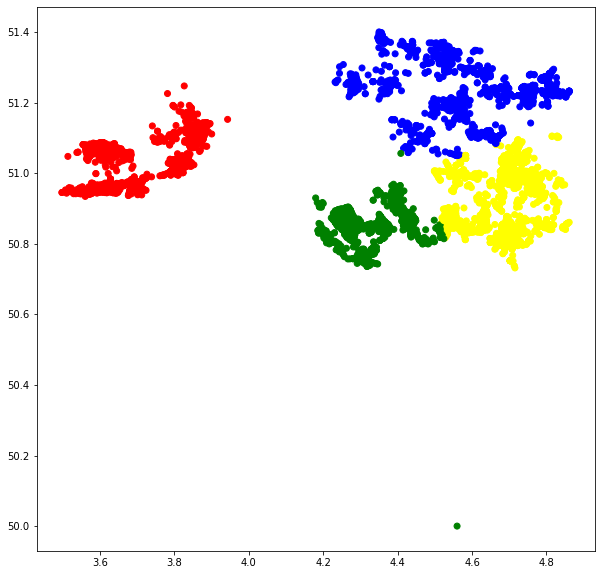

In [7]:
### Clustering the customer positions

## Clustering the longitude and latitude

from sklearn.cluster import KMeans
plt.figure(figsize = (10,10))

# initialize the cluster algorithm with 4 classes
kmeans_model = KMeans(n_clusters=4)

# fit the kmeans model onto the data
kmeans_model.fit(hvc_hvposition[["LAT","LONG"]])

# get all the cluster labels
cluster_labels = kmeans_model.labels_

# define color map
color_map = {0: "green", 1: "red", 2: "blue", 3: "yellow"}

# get colors for each cluster label
cluster_colors = [color_map[label] for label in cluster_labels]

# plot data with cluster colors
plt.scatter(hvc_hvposition["LAT"], hvc_hvposition["LONG"], color=cluster_colors)
plt.show()

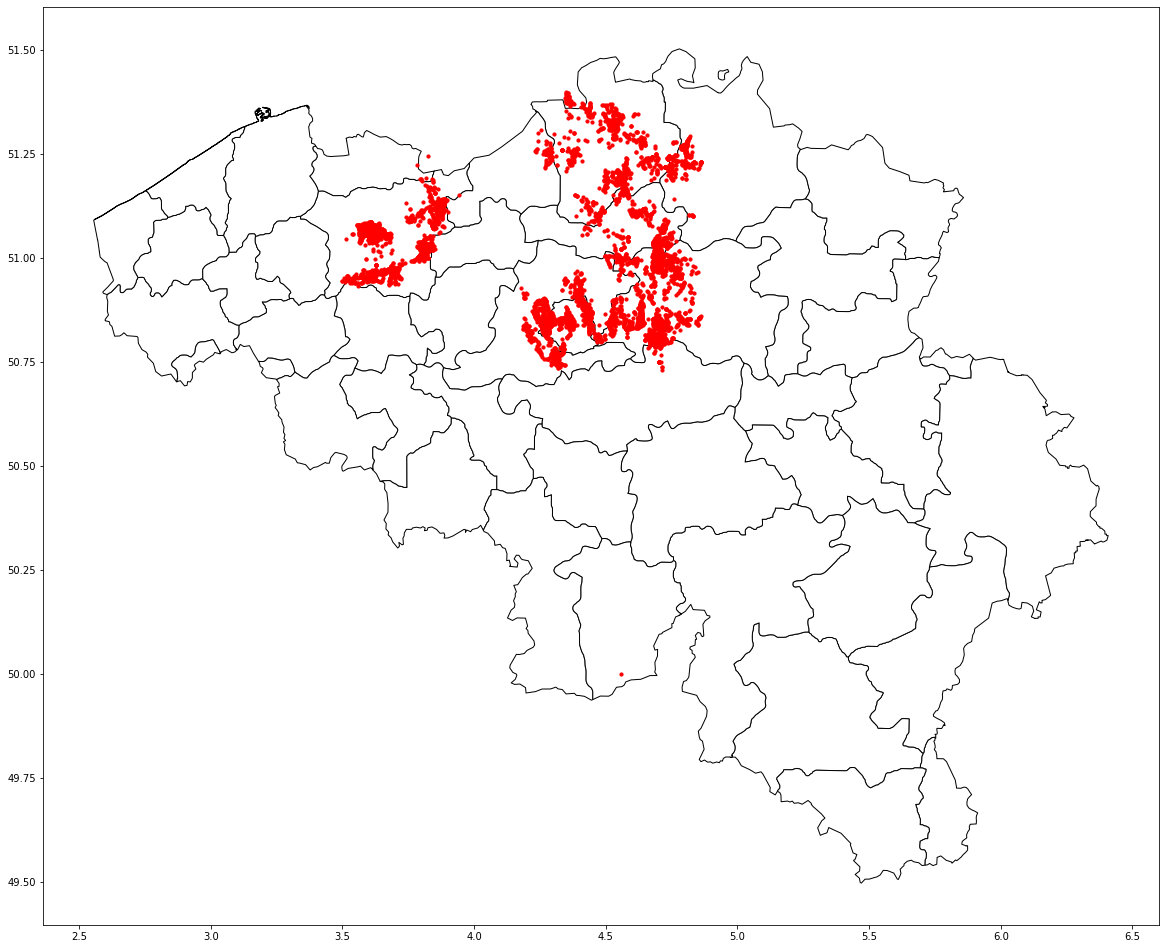

In [9]:
# adding a map
belgium = gpd.read_file("./data/Arrondissementen.json")
crs = 'epsg:4326'
base = belgium.plot(color='white', edgecolor='black', figsize = (20,20))
gdf = gpd.GeoDataFrame(hvc_hvposition, crs = crs,geometry=gpd.points_from_xy(hvc_hvposition["LAT"], hvc_hvposition["LONG"]))


gdf.plot(ax = base, color = "red",markersize = 10)

plt.show()

## 3.2 What do the  customers buy? 

In [10]:
customer_id = 721110.0

In [11]:
# join transactions with transaction details with products
transactions_products = hvc_hvvisitresult.merge(hvc_visitresultdetails, on="HVVISITRESULT_NRID", how="inner")\
                                         .merge(hvc_ar0, on="AR0_NRID", how="inner") 

In [12]:
# check
transactions_products.head(3)

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM,VISITRESULTDETAILS_NRID,AR0_NRID,QUANTITY,DESCRIPTION,CATEGORY,FAMILY,PRICE
0,55681456,719952,23186288605042,2,2021-10-24 12:20:01,2019-05-06,16.9,cash,55681457,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4
1,55681507,1453609,19946584592834,2,2021-10-24 12:13:50,2019-05-06,7.4,cash,55681508,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4
2,55714770,1246568,18934048107254,2,2021-10-24 22:08:39,2019-05-06,11.1,cash,55714771,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4


In [13]:
# get all the transactions for customer
transactions_products_customer = transactions_products[transactions_products["SO0_NRID"] == customer_id]

# get all transactions with positive outcome
transactions_products_customer = transactions_products_customer[transactions_products_customer["HVOUTCOME_NRID"] == 2]

In [14]:
# get total number of products bought by the customer
transactions_products_customer["QUANTITY"].sum()

22.0

## 3.3 Unique list of unique products a customer bought

In [15]:
# define a function that accepts a customer id, the transactions data, transactions details data and product data
def get_products(cust_id, transactions, transaction_details, products):
    

    # join transactions with transaction details with products
    transactions_products = transactions.merge(transaction_details, on="HVVISITRESULT_NRID", how="inner") \
                                        .merge(products, on="AR0_NRID", how="inner")
    
    # get transactions of customer 
    transactions_products_cust = transactions_products[transactions_products["SO0_NRID"] == cust_id]
    
    # only get transactions of succesfull visits
    transactions_products_cust = transactions_products_cust[transactions_products_cust["HVOUTCOME_NRID"] == 2]
    
    # get total amount of products bought by the customer
    total_products = transactions_products_cust["QUANTITY"].sum()
    
    # get total number of unique products bought by the customer
    total_unique_products = len(transactions_products_cust["DESCRIPTION"].unique())
    
    # return
    return(total_products, total_unique_products)

In [16]:
# check
get_products(cust_id=721110.0, 
                  transactions=hvc_hvvisitresult, 
                  transaction_details=hvc_visitresultdetails, 
                  products=hvc_ar0)

(22.0, 10)

## 3.4 Which customers have the highest CLV?



In [17]:
def get_clv(cust_id):
    
    # get customer transactions
    transactions=hvc_hvvisitresult
    cust_transactions = transactions[transactions["SO0_NRID"] == cust_id]
    # get transactions with positive outcome
    cust_transactions_pos = cust_transactions[cust_transactions["HVOUTCOME_NRID"] == 2]
    # get clv
    clv = np.sum(cust_transactions["AMOUNT"])
    # return clv
    return(clv)

In [18]:
#add a clv column to every customer
all_clv = []
#making a list of clv's 
for i in range(len(hvc_so0)):
    all_clv.append(get_clv(cust_id=hvc_so0.iloc[i,0]))
#add the list to the df
hvc_so0_with_clv = hvc_so0.assign(CLV = all_clv )

In [19]:
#sort by clv
hvc_so0_with_clv.sort_values(by="CLV")

,SO0_NRID,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE,CLV
5498,25072084353446,219018687,Private,3950,nl-BE,All time,-9.6
5393,23125976574636,219021882,Private,3930,nl-BE,All time,-0.4
3478,56370689,289758474,Private,3650,nl-BE,All time,0.0
3802,70703051,289662608,Private,3500,nl-BE,All time,0.0
3824,70921796,219018687,Private,3950,nl-BE,All time,0.0
...,...,...,...,...,...,...,...
1281,1250991,289416949,Horeca,3582,nl-BE,All time,7041.7
1973,728498,219018687,Horeca,3950,nl-BE,All time,8503.2
4100,20256376185452,289418953,Catering,3550,nl-BE,All time,8899.8
2210,1451799,289762482,Horeca,3640,nl-BE,All time,9938.9


In [20]:
# get the counts for customer type
hvc_so0["CUST_TYPE"].value_counts()

Private     5579
Horeca        97
Catering      33
Name: CUST_TYPE, dtype: int64

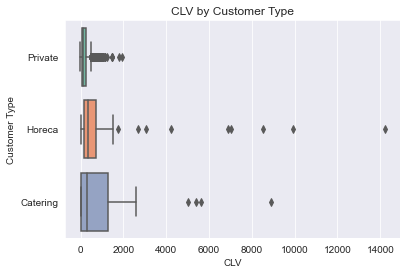

In [61]:
#Boxplot 
sns.set_style('darkgrid')
sns.set_palette('Set2')
plt.title('CLV by Customer Type')
sns.boxplot(data=hvc_so0_with_clv, x='CLV', y='CUST_TYPE')
plt.xlabel('CLV')
plt.ylabel('Customer Type')
plt.savefig('./Graphs/CLV by Customer Type.png')
plt.show()

In [22]:
#Sales by customer type in a certain year

def sales_by_customer_type(desired_year):

    # get the month of each transaction date and store it in new column
    hvc_hvvisitresult["MONTH"] = hvc_hvvisitresult["DATEONLY"].apply(lambda x: x.month)

    #merge
    transactions_2020 = hvc_hvvisitresult.merge(hvc_so0,on="SO0_NRID", how ="inner")

    # get transactions from 2020 only
    transactions_2020 = transactions_2020[(transactions_2020["DATEONLY"] >= pd.Timestamp(year=desired_year, day=1, month=1)) & (transactions_2020["DATEONLY"] < pd.Timestamp(year=desired_year + 1, month=1, day=1))]

    # get transactions with succesfull outcome
    transactions_2020 = transactions_2020[transactions_2020["HVOUTCOME_NRID"] == 2]


    # get transactions by 'private customers'
    private_transactions_2020 = transactions_2020[transactions_2020["CUST_TYPE"] == "Private"]

    # get the total sales for each month for 'private customers'
    private_monthly_sales = private_transactions_2020.groupby("MONTH")["AMOUNT"].sum().reset_index()

    # get transactions by 'Horeca customers'
    horeca_transactions_2020 = transactions_2020[transactions_2020["CUST_TYPE"] == "Horeca"]

    # get the total sales for each month for 'Horeca customers'
    horeca_monthly_sales = horeca_transactions_2020.groupby("MONTH")["AMOUNT"].sum().reset_index()

    # get transactions by 'Catering customers'
    catering_transactions_2020 = transactions_2020[transactions_2020["CUST_TYPE"] == "Catering"]

    # get the total sales for each month for 'Catering customers'
    catering_monthly_sales = catering_transactions_2020.groupby("MONTH")["AMOUNT"].sum().reset_index()

    # Barplot
    n_months = 12
    fig, ax = plt.subplots()
    index = np.arange(n_months)
    bar_width = 0.20
    opacity = 0.7

    rects1 = plt.bar(index, private_monthly_sales["AMOUNT"], bar_width,
    alpha=opacity,
    color='#FFD57A',
    label='Private')
                                              
    rects2 = plt.bar(index + bar_width, horeca_monthly_sales["AMOUNT"], bar_width,
    alpha=opacity,
    color='#ffb923',
    label='Horeca')

    rects3 = plt.bar(index + 2*bar_width, catering_monthly_sales["AMOUNT"], bar_width,
    alpha=opacity,
    color='#FF9323',
    label='Catering')

    plt.xlabel('Customer type')
    plt.ylabel('Sales')
    plt.title('Sales by customer type in '+str(desired_year))
    plt.xticks(index + bar_width, ('JAN', 'FEB', 'MAR', 'APR', 'MAI', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
    plt.legend()
    plt.savefig('Sales by customer type in '+str(desired_year))
    plt.tight_layout()


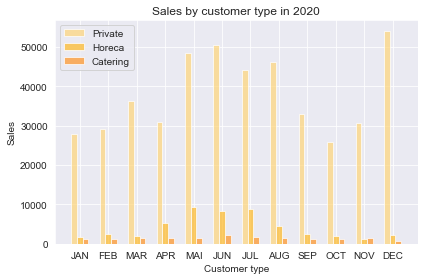

In [24]:
#sales by customer in 2020
sales_by_customer_type(2020)

## 3.5 How often did a customer purchase at the company at different days 

In [25]:
def get_frequency(cust_id):
    
    transactions = hvc_hvvisitresult
    
    # get transactions made by customer
    transactions_cust = transactions[hvc_hvvisitresult["SO0_NRID"] == cust_id]

    # get transactions from succesfull visits
    transactions_cust = transactions_cust[transactions_cust["HVOUTCOME_NRID"] == 2]

    # get total number of unique days on which customer made a purchase
    frequency = len(transactions_cust)
    
    # return
    return(frequency)

In [26]:
# check
get_frequency(724147)

32

## 3.6 Which customers left the company?

In [27]:
#Linear regression plots

def get_regression_sales(customer_id, year_regression):
    
    #get the month of each transaction date and store it in new column
    hvc_hvvisitresult["MONTH"] = hvc_hvvisitresult["DATEONLY"].apply(lambda x: x.month)

    #merge
    transactions = hvc_hvvisitresult.merge(hvc_so0,on="SO0_NRID", how ="inner")
    
    #get transactions from desired_year
    transactions = transactions[(transactions["DATEONLY"] >= pd.Timestamp(year=year_regression, day=1, month=1)) & (transactions["DATEONLY"] < pd.Timestamp(year=year_regression + 1, month=1, day=1))]

    #get transactions with succesfull outcome
    transactions = transactions[transactions["HVOUTCOME_NRID"] == 2]
    
    #get transactions from customer with specific id 
    transactions_unique_cust = transactions[transactions["SO0_NRID"] == customer_id ]
    
    # get the total sales for each month for customers
    sales_unique_cust = transactions_unique_cust.groupby("MONTH")["AMOUNT"].sum().reset_index() 
    print(sales_unique_cust)
    sales_unique_cust_fixed = sales_unique_cust
    sales_unique_cust_fixed["MONTH"] = sales_unique_cust["MONTH"]-1
    
    
    g = sns.lmplot(x="MONTH", y="AMOUNT", data=sales_unique_cust_fixed, fit_reg=True, line_kws={'color': '#ffb923'}, scatter_kws={'color': '#ffb923'})
    
    g.set(ylim=(0, None))
    plt.xlabel("Months")
    plt.ylabel("Sales")
    plt.title("Sales of Customer " + str(customer_id) + " in " + str(year_regression))
    plt.xticks(range(12), ('JAN', 'FEB', 'MAR', 'APR', 'MAI', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'))
    plt.tight_layout()
    plt.savefig('./Graphs/regression.png')
    return plt.show()


   MONTH  AMOUNT
0      2    47.1
1      3    49.0
2      5    15.0
3      6    22.6
4      8    39.9
5      9    24.7
6     10    14.9
7     11     7.6
8     12     7.6


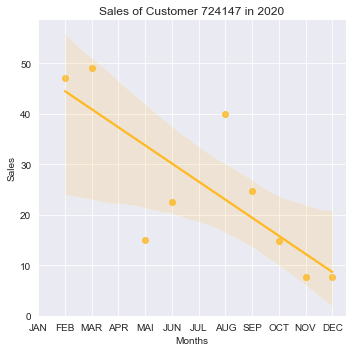

In [28]:
# Regression test
get_regression_sales(customer_id=724147, year_regression=2020)

In [29]:
#LINEAR REGRESSION MODEL

#merge
transactions = hvc_hvvisitresult.merge(hvc_so0,on="SO0_NRID", how ="inner")

#get transactions with succesfull outcome
transactions = transactions[transactions["HVOUTCOME_NRID"] == 2]

transactions
    

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM,MONTH,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE
0,55681456,719952,23186288605042,2,2021-10-24 12:20:01,2019-05-06,16.9,cash,5,219019962,Private,3950,nl-BE,All time
1,55248854,719952,23186288605042,2,2021-10-24 12:46:43,2019-04-22,7.4,cash,4,219019962,Private,3950,nl-BE,All time
2,54761459,719952,23186288605042,2,2021-10-24 12:32:05,2019-04-08,7.4,cash,4,219019962,Private,3950,nl-BE,All time
4,54354469,719952,23186288605042,2,2021-10-24 17:14:48,2019-03-25,16.9,cash,3,219019962,Private,3950,nl-BE,All time
7,52658514,719952,23186288605042,2,2021-10-24 11:43:41,2019-01-28,7.4,cash,1,219019962,Private,3950,nl-BE,All time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240395,73495755,1398687,24034952445848,2,2021-10-24 08:41:10,2020-12-14,9.9,cash,12,289657598,Private,3500,nl-BE,All time
240397,73626203,727026,25146868694050,2,2021-10-24 11:32:12,2020-12-16,21.0,cash,12,219021241,Private,3910,nl-BE,All time
240407,73339096,25849793425152,19946584592834,2,2021-10-24 11:26:24,2020-12-09,29.7,cash,12,289764486,Private,3680,nl-BE,All time
240412,72976174,25616776446438,19946584592834,2,2021-10-24 12:13:03,2020-11-30,7.1,cash,11,289757472,Private,3960,nl-BE,All time


In [30]:
#imputing missing vallues 
for col in transactions.columns:
    # get number of missing values for column
    num_miss = sum(transactions[col].isnull())
    # print
    print(col, num_miss)

HVVISITRESULT_NRID 0
SO0_NRID 0
AM0_NRID 0
HVOUTCOME_NRID 0
VISITDATE 0
DATEONLY 0
AMOUNT 0
PAYMENTTERM 1629
MONTH 0
HVROUTETEMPLATE_NRID 0
CUST_TYPE 0
POSTCODE 0
LANGUAGE 0
SEASON_TYPE 1


In [31]:
transactions

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM,MONTH,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE
0,55681456,719952,23186288605042,2,2021-10-24 12:20:01,2019-05-06,16.9,cash,5,219019962,Private,3950,nl-BE,All time
1,55248854,719952,23186288605042,2,2021-10-24 12:46:43,2019-04-22,7.4,cash,4,219019962,Private,3950,nl-BE,All time
2,54761459,719952,23186288605042,2,2021-10-24 12:32:05,2019-04-08,7.4,cash,4,219019962,Private,3950,nl-BE,All time
4,54354469,719952,23186288605042,2,2021-10-24 17:14:48,2019-03-25,16.9,cash,3,219019962,Private,3950,nl-BE,All time
7,52658514,719952,23186288605042,2,2021-10-24 11:43:41,2019-01-28,7.4,cash,1,219019962,Private,3950,nl-BE,All time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240395,73495755,1398687,24034952445848,2,2021-10-24 08:41:10,2020-12-14,9.9,cash,12,289657598,Private,3500,nl-BE,All time
240397,73626203,727026,25146868694050,2,2021-10-24 11:32:12,2020-12-16,21.0,cash,12,219021241,Private,3910,nl-BE,All time
240407,73339096,25849793425152,19946584592834,2,2021-10-24 11:26:24,2020-12-09,29.7,cash,12,289764486,Private,3680,nl-BE,All time
240412,72976174,25616776446438,19946584592834,2,2021-10-24 12:13:03,2020-11-30,7.1,cash,11,289757472,Private,3960,nl-BE,All time


In [32]:
def get_regression_sales_info(customer_id):
    
    info_reg_no_sales = [1.0, 0.0,-1.0]
    
    try:
        #get the month of each transaction date and store it in new column
        hvc_hvvisitresult["MONTH"] = hvc_hvvisitresult["DATEONLY"].apply(lambda x: x.month)

        #merge
        transactions = hvc_hvvisitresult.merge(hvc_so0,on="SO0_NRID", how ="inner")
    
        #get transactions from desired_year
        transactions = transactions[(transactions["DATEONLY"] >= pd.Timestamp(year=2020, day=1, month=1)) & (transactions["DATEONLY"] < pd.Timestamp(year=2021, month=1, day=1))]

        #get transactions with succesfull outcome
        transactions = transactions[transactions["HVOUTCOME_NRID"] == 2]
    
        #get transactions from customer with specific id 
        transactions_unique_cust = transactions[transactions["SO0_NRID"] == customer_id ]
    
        # get the total sales for each month for customers
        sales_unique_cust = transactions_unique_cust.groupby("MONTH")["AMOUNT"].sum().reset_index() 
        sales_unique_cust_fixed = sales_unique_cust
        sales_unique_cust_fixed["MONTH"] = sales_unique_cust["MONTH"]-1
    
        #regression model
        x = np.array(sales_unique_cust_fixed["MONTH"]).reshape((-1,1))
        y = np.array(sales_unique_cust_fixed["AMOUNT"])
        model = LinearRegression()
        model.fit(x,y)
    
        #coefficient of determination
        r_sq = model.score(x,y)
    
        #intercept and slope
        intercept = model.intercept_
        slope = model.coef_
    
        info_reg = [r_sq, intercept,slope[0]]
    
        return info_reg
    
    except ValueError as v:
        return info_reg_no_sales
        
        

In [36]:
#test regression
get_regression_sales_info(customer_id=721110.0)

[1.0, 9.5, 0.0]

In [37]:
#setting thresholds for leaving customers
threshold_r_sq = 0.500000000
threshold_slope = 0.000

In [38]:
#testing with iloc
get_regression_sales_info(customer_id=hvc_so0.iloc[5,0])

[1.0, 0.0, -1.0]

In [39]:
#getting a list of leaving customers
leaving_customers = []

for i in range(len(hvc_so0)):
    #getting the neccesary information 
    info_regression = get_regression_sales_info(customer_id=hvc_so0.iloc[i,0])
    try:
        #checking with thresholds
        if ((info_regression[0] > threshold_r_sq) and (info_regression[2] < threshold_slope)):
            leaving_customers.append(hvc_so0.iloc[i,0])    
        #if no sales records in 2020
        elif (info_regression == [1.0, 0.0,-1.0]):
            leaving_customers.append(hcv_so0.iloc[i,0])
        
    except TypeError:
        print("TypeError")

KeyboardInterrupt: 

In [ ]:
# save numpy array as npy fil
# save to npy file
np.save('./data/leaving_customers.npy', leaving_customers)

In [42]:
# load numpy array from npy file
# load array
leaving_customers = np.load('./data/leaving_customers.npy')

In [43]:
leaving_customers

array([], dtype=float64)

In [44]:
#customers with bad reviews
hvc_all_bad_reviews = hvc_customer_reviews[(hvc_customer_reviews["REVIEW"] == "Not completely satisfied") | (hvc_customer_reviews["REVIEW"] == "Very bad service, very unsatisfied")]
customers_all_bad_reviews = hvc_all_bad_reviews["SO0_NRID"].to_numpy()

In [15]:
hvc_terrible_reviews = hvc_customer_reviews[(hvc_customer_reviews["REVIEW"] == "Very bad service, very unsatisfied")]
customers_terrible_reviews = hvc_terrible_reviews["SO0_NRID"].to_numpy()

In [16]:
#check the intersection of bad customers with the leaving customers
bad_review_leaving = np.intersect1d(leaving_customers,customers_all_bad_reviews)

#check the intersection of terrible customers with the leaving customers
terrible_review_leaving = np.intersect1d(leaving_customers,customers_terrible_reviews)

NameError: name 'leaving_customers' is not defined

In [ ]:
#calculating the proportion of all bad reviews that are leaving customers out of the total customers with all bad reviews
proportion_bad = int((100*len(bad_review_leaving))/len(customers_all_bad_reviews))
proportion_bad

#half of the customers that gave a bad review in 2019 are leaving customers in 2020 according to our regression 

In [19]:
#calculating the proportion of terrible reviews that are leaving customers out of the total customers with terrible reviews
proportion_terrible = int((100*len(terrible_review_leaving))/len(customers_terrible_reviews))
proportion_terrible

NameError: name 'terrible_review_leaving' is not defined

## 3.7 Are there factors that the company can change in order to decrease the churning rate?

In [45]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'Spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Summer': pd.date_range(start='21/06/'+year, end='20/09/'+year),
               'Autumn': pd.date_range(start='21/09/'+year, end='20/12/'+year)}
    if date in seasons['Spring']:
        return 'Spring'
    if date in seasons['Summer']:
        return 'Summer'
    if date in seasons['Autumn']:
        return 'Autumn'
    else:
        return 'Winter'

In [46]:
#Check if the customer is visited at the right moment
#comparing amounts of open door but no purchase on a certain date with the preferred time for visits
hvc_hvvisitresult_nothingneeded = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 0]
hvc_hvvisitresult_nothingneeded.drop(axis = 1,labels = "PAYMENTTERM")

hvc_hvvisitresult_nothingneeded_so0 = pd.merge(hvc_hvvisitresult_nothingneeded, hvc_so0, on = "SO0_NRID")

hvc_hvvisitresult_nothingneeded_so0.drop(axis = 1, labels = "PAYMENTTERM")

#Christmas
hvc_hvvisitresult_nothingneeded_so0_christmas = hvc_hvvisitresult_nothingneeded_so0[hvc_hvvisitresult_nothingneeded_so0["SEASON_TYPE"] == "Christmas"]

christmas_false = []
for index, row in hvc_hvvisitresult_nothingneeded_so0_christmas.iterrows():
    if(row.DATEONLY.month != 12):
        christmas_false.append(index)
christmas_wrongproportion = int((len(christmas_false)/len(hvc_hvvisitresult_nothingneeded_so0_christmas)*100))
print("Christmas: ", christmas_wrongproportion)

#Function
def season_proportion(season):
    hvc_hvvisitresult_nothingneeded_so0_Season = hvc_hvvisitresult_nothingneeded_so0[hvc_hvvisitresult_nothingneeded_so0["SEASON_TYPE"] == season]

    Season_false = []
    for index, row in hvc_hvvisitresult_nothingneeded_so0_Season.iterrows():
        if(season_of_date(row.DATEONLY) == season):
            Season_false.append(index)
    Season_wrongproportion = int((len(Season_false)/len(hvc_hvvisitresult_nothingneeded_so0_Season)*100))
    print(season + ": ", Season_wrongproportion)
    return Season_wrongproportion
    
    
summer_wrongproportion = season_proportion("Summer")
winter_wrongproportion = season_proportion("Winter")

Christmas:  89
Summer:  25
Winter:  0


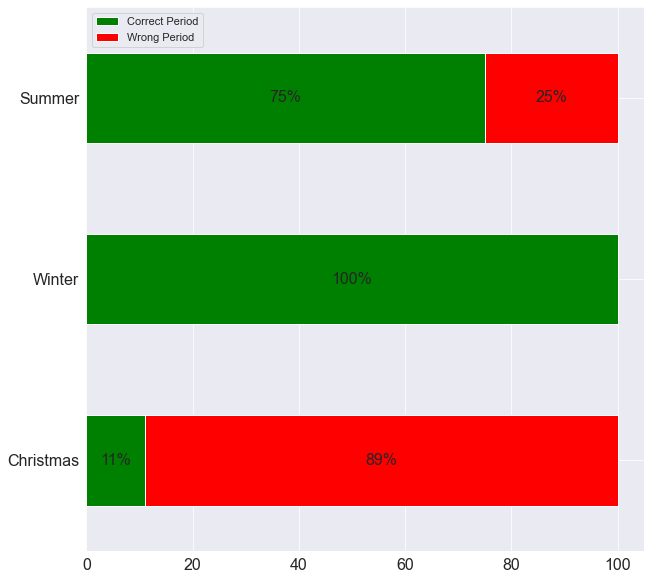

In [47]:
## Making a horizontal stacked bar chart
from matplotlib.colors import LinearSegmentedColormap

#making a df
data = [['Christmas', 100 - christmas_wrongproportion, christmas_wrongproportion], ['Winter', 100 - winter_wrongproportion, winter_wrongproportion], ['Summer', 100 - summer_wrongproportion, summer_wrongproportion]]
df = pd.DataFrame(data, columns = ['Season_Types', 'Wrong_Period',"Correct_Period"])

## making plot
ax = df.plot(kind='barh', stacked=True, figsize=(10, 10), color = ["green","red"])

for c in ax.containers:
    
    # customize the label to account for cases when there might not be a bar section
    labels = [f'{w:.0f}%' if (w := v.get_width()) > 0 else '' for v in c ]
    
    # set the bar label
    ax.bar_label(c, labels=labels, label_type='center', fontsize = 16)
    
    
ax.legend(["Correct Period", "Wrong Period"],loc="upper left", fontsize = 11)
plt.xticks([0,20,40,60,80,100], fontsize = 16)
plt.yticks(np.arange(3), df["Season_Types"], fontsize = 16)
plt.savefig('./Graphs/Correct_Visit_Period.png')
plt.show()

In [48]:
# Turnover customers
hvc_hvvisitresult_nothingneeded = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 0]
visit_turnover = (len(hvc_hvvisitresult_nothingneeded)/len(hvc_hvvisitresult))*100
visit_turnover

38.99715076014392

In [49]:
# check if the customer closed door is visited between 9 and 17

hvc_hvvisitresult_nothome = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 1]
hvc_hvvisitresult_nothome.drop(axis = 1,labels = "PAYMENTTERM")

Correct_Time = []
Wrong_Time = []

starttime= datetime.time(9,0,0)
endtime = datetime.time(17,0,0)

for index, row in hvc_hvvisitresult_nothome.iterrows():
    if(row.VISITDATE.time() > starttime and row.VISITDATE.time() < endtime):
        Wrong_Time.append(index)
Wrong_Time_proportion = int(100*(len(Wrong_Time)/len(hvc_hvvisitresult_nothome)))
print(Wrong_Time_proportion)

81


## 3.8 Do customers have different buying patterns during the weekend?

In [50]:
hvc_hvdayofweek

,HVDAYOFWEEK_NRID,DAY
0,1,Sunday
1,2,Monday
2,3,Tuesday
3,4,Wednesday
4,5,Thursday
5,6,Friday
6,7,Saturday


In [51]:
#replacing numbers by the days
transactions_with_days = transactions.merge(hvc_hvroutetemplate,on="HVROUTETEMPLATE_NRID",how="inner")

#sorting transactions
transactions_with_days = transactions_with_days.sort_values(by='HVDAYOFWEEK_NRID')

#replacing numbers with days
transactions_with_days["HVDAYOFWEEK_NRID"].replace({1 : "Sunday", 2 : "Monday",  3 : "Tuesday", 4: "Wednesday", 5 : "Thursday" , 6: "Friday", 7 : "Saturday" }, inplace=True)

transactions_with_days

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM,MONTH,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE,REGION,WEEKORDER,HVDAYOFWEEK_NRID
78929,57785797,19672260568052,24226444135852,2,2021-10-24 09:27:39,2019-07-02,95.9,tbp,7,70671404,Catering,3950,nl-BE,All time,C04,1,Sunday
36731,71086733,62254085,24034952445848,2,2021-10-24 15:37:23,2020-09-19,35.5,cash,9,289655594,Private,3500,nl-BE,All time,C17,1,Monday
36730,72120180,62254085,24034952445848,2,2021-10-24 17:31:02,2020-10-31,31.9,cash,10,289655594,Private,3500,nl-BE,All time,C17,1,Monday
36729,69910925,62254085,24034952445848,2,2021-10-24 15:29:38,2020-08-08,9.5,cash,8,289655594,Private,3500,nl-BE,All time,C17,1,Monday
36728,69910914,62254085,24034952445848,2,2021-10-24 15:29:25,2020-08-08,27.8,cash,8,289655594,Private,3500,nl-BE,All time,C17,1,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55227,61619467,727971,23845760556442,2,2021-10-24 13:05:02,2019-11-13,18.4,cash,11,219024456,Private,3950,nl-BE,All time,C04,2,Friday
55226,62060842,727971,24705284396450,2,2021-10-24 12:48:44,2019-11-27,19.5,cash,11,219024456,Private,3950,nl-BE,All time,C04,2,Friday
55225,60981117,727971,23845760556442,2,2021-10-24 13:26:15,2019-10-16,9.9,cash,10,219024456,Private,3950,nl-BE,All time,C04,2,Friday
55223,58092997,727971,23186288605042,2,2021-10-24 14:36:48,2019-07-10,29.4,cash,7,219024456,Private,3950,nl-BE,All time,C04,2,Friday


In [52]:
# get the counts for days of week
transactions_with_days["HVDAYOFWEEK_NRID"].value_counts()

Wednesday    18179
Tuesday      17781
Thursday     16598
Friday       14698
Monday       11673
Sunday           1
Name: HVDAYOFWEEK_NRID, dtype: int64

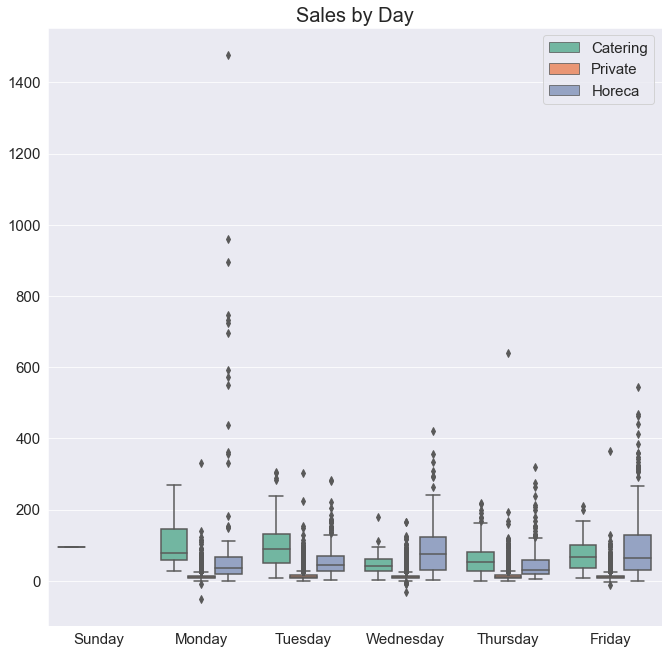

In [53]:
#Boxplot 
sns.set_style('darkgrid')
sns.set_palette('Set2')
plt.figure(figsize=(11,11))
plt.title('Sales by Day',fontsize = 20)
sns.boxplot(data=transactions_with_days, x='HVDAYOFWEEK_NRID', y='AMOUNT', hue="CUST_TYPE")
plt.xlabel('')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('')
plt.legend(title="", fontsize=15)
plt.savefig('./Graphs/Sales by Day.png')
plt.show()


## 3.9 Do customer sales differ across different cities? Is there a relationship between customer  sales and average income per inhabitant (and other factors)?

We tried to solve this question, but we encountered problems when changing the postcode. We did not have enough time to fix our problem.

In [65]:
# import customer locations
pos_df = pd.read_csv("./data/HVC_HVPOSITION_CORRECT.csv", sep=";")

# join
cust_pos_df = pd.merge(left=hvc_so0, right=pos_df, on="SO0_NRID", how="inner")

In [66]:
# import city data from belgium, which was downloaded from the internet
postcodes_df = pd.read_csv("./data/zipcode-belgium.csv", header=None)
postcodes_df.columns = ["POSTCODE", "LOCATION", "LAT", "LONG"]

In [67]:
cust_pos_df

,SO0_NRID,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE,LAT,LONG
0,721104,219020601,Private,3930,nl-BE,All time,3.591994,50.956946
1,721110,219020601,Private,3930,nl-BE,All time,3.591994,50.956946
2,721121,219020601,Private,3930,nl-BE,All time,3.604466,50.958559
3,721126,219020601,Private,3930,nl-BE,All time,3.603056,50.958251
4,721131,219020601,Private,3930,nl-BE,All time,3.603824,50.958419
...,...,...,...,...,...,...,...,...
5692,26222057226946,289662608,Private,3500,nl-BE,All time,4.699692,50.846754
5693,26651656233234,219020601,Horeca,3930,nl-BE,All time,3.523737,50.948597
5694,26869549647542,289760478,Private,3680,nl-BE,All time,4.579471,51.278961
5695,26959353239340,289418953,Private,3550,nl-BE,All time,4.423990,50.889961


In [68]:
pos_df

,SO0_NRID,LAT,LONG
0,724196,3.576301,51.053585
1,724219,3.572461,51.047222
2,724231,3.571065,51.044908
3,724236,3.568838,51.041573
4,724241,3.567592,51.040040
...,...,...,...
5692,25332076406640,4.573422,51.154883
5693,25335568268048,3.844218,51.119432
5694,25343276433048,3.867731,51.061335
5695,25345568238048,3.802616,51.038216


In [69]:
# join with customer data
cust_pos_postcodes_df = pd.merge(left=cust_pos_df, right=postcodes_df, on="POSTCODE", how="inner")
cust_pos_postcodes_df

,SO0_NRID,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE,LAT_x,LONG_x,LOCATION,LAT_y,LONG_y
0,721104,219020601,Private,3930,nl-BE,All time,3.591994,50.956946,Achel,5.479290,51.268431
1,721104,219020601,Private,3930,nl-BE,All time,3.591994,50.956946,Hamont,5.531287,51.254585
2,721104,219020601,Private,3930,nl-BE,All time,3.591994,50.956946,Hamont-Achel,5.512870,51.254764
3,721110,219020601,Private,3930,nl-BE,All time,3.591994,50.956946,Achel,5.479290,51.268431
4,721110,219020601,Private,3930,nl-BE,All time,3.591994,50.956946,Hamont,5.531287,51.254585
...,...,...,...,...,...,...,...,...,...,...,...
15798,1398086,289659602,Private,3600,nl-BE,All time,4.620606,50.996574,Genk,5.500146,50.965486
15799,1398096,289659602,Private,3600,nl-BE,All time,4.619796,50.998291,Genk,5.500146,50.965486
15800,1398101,289659602,Private,3600,nl-BE,All time,4.619796,50.998291,Genk,5.500146,50.965486
15801,1398106,289659602,Private,3600,nl-BE,All time,4.618987,51.000008,Genk,5.500146,50.965486


In [98]:
def change_postcode_customer(cust_id):
    # get index of customer
    index = cust_pos_postcodes_df[cust_pos_postcodes_df['SO0_NRID']==cust_id].index.values.astype(int)[0]
    index_so0 = hvc_so0[hvc_so0['SO0_NRID']==cust_id].index.values.astype(int)[0]
    # get long and lat from customer
    cust_long = float(cust_pos_postcodes_df["LONG_x"].iloc[index])
    cust_lat = float(cust_pos_postcodes_df["LAT_x"].iloc[index])
    
    closest_city = None
    closest_dist = 10000000
    
    for i in range(len(postcodes_df)):
        city_name = postcodes_df["LOCATION"].iloc[i]
        city_long = float(postcodes_df["LONG"].iloc[i])
        city_lat = float(postcodes_df["LAT"].iloc[i])
        
        city=(city_lat, city_long)
        cust=(cust_lat, cust_long)
        
        dist = hs.haversine(city,cust)
        if dist < closest_dist:
            closest_city = city_name
            closest_dist = dist
    
    city_postcode = postcodes_df[postcodes_df["LOCATION"] == closest_city]["POSTCODE"]
    hvc_so0.at[index_so0, 'POSTCODE'] = city_postcode

In [99]:
#change postcode for all customers
for index,row  in cust_pos_df.iterrows():
    cust_id = cust_pos_df.iloc[index,0]
    change_postcode_customer(cust_id)

ValueError: setting an array element with a sequence.

In [82]:
hvc_so0.tail(100)

,SO0_NRID,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE
5609,25628189468344,289764486,Private,3680,nl-BE,All time
5610,25631676416438,289757472,Private,3640,nl-BE,All time
5611,25635056656642,219019324,Private,3950,nl-BE,All time
5612,25642372403248,289413943,Private,3582,nl-BE,All time
5613,25642444116644,289759476,Private,3640,nl-BE,All time
...,...,...,...,...,...,...
5704,26651656233234,219020601,Horeca,3930,nl-BE,All time
5705,26707966298860,289760478,Horeca,3650,nl-BE,All time
5706,26869549647542,289760478,Private,3680,nl-BE,All time
5707,26959353239340,289418953,Private,3550,nl-BE,All time


In [91]:
#dividing into regions
brussels = hvc_so0[(hvc_so0["POSTCODE"]>=1000) & (hvc_so0["POSTCODE"] <= 1299)]
walloon_brabant = hvc_so0[(hvc_so0["POSTCODE"]>=1300) & (hvc_so0["POSTCODE"] <= 1499)]
flemish_brabant = hvc_so0[(hvc_so0["POSTCODE"]>=1500) & (hvc_so0["POSTCODE"] <= 1999)]
antwerp = hvc_so0[(hvc_so0["POSTCODE"]>=2000) & (hvc_so0["POSTCODE"] <= 2999)]
flemish_brabant_2 = hvc_so0[(hvc_so0["POSTCODE"]>=3000) & (hvc_so0["POSTCODE"] <= 3499)]
limburg = hvc_so0[(hvc_so0["POSTCODE"]>=3500) & (hvc_so0["POSTCODE"] <= 3999)]
liège = hvc_so0[(hvc_so0["POSTCODE"]>=4000) & (hvc_so0["POSTCODE"] <= 4999)]
namur = hvc_so0[(hvc_so0["POSTCODE"]>=5000) & (hvc_so0["POSTCODE"] <= 5999)]
hainaut = hvc_so0[(hvc_so0["POSTCODE"]>=6000) & (hvc_so0["POSTCODE"] <= 6599)]
luxembourg = hvc_so0[(hvc_so0["POSTCODE"]>=6600) & (hvc_so0["POSTCODE"] <= 6999)]
hainaut_2 = hvc_so0[(hvc_so0["POSTCODE"]>=7000) & (hvc_so0["POSTCODE"] <= 7999)]
west_flanders = hvc_so0[(hvc_so0["POSTCODE"]>=8000) & (hvc_so0["POSTCODE"] <= 8999)]
east_flanders = hvc_so0[(hvc_so0["POSTCODE"]>=9000) & (hvc_so0["POSTCODE"] <= 9999)]

In [92]:
#get aggregate sales for a certain region
def get_sales_region(region):
    #merge region df with visitresults
    region = region.merge(hvc_hvvisitresult, on="SO0_NRID", how="inner")
    
    #sum of all sales
    sales_region = region["AMOUNT"].sum()
    return sales_region

In [97]:
#test function
get_sales_region(antwerp)

0.0